<a href="https://colab.research.google.com/github/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/blob/main/Notebooks/4_Modelo_NO2_vehiculos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 4: Modelado de la concentración de NO2 en función del conteo vehicular y variables meteorológicas
##1.Librerías y datos
Como en las notebooks anteriores, cargamos las librerías necesarias.

Además, se descarga el repositorio de este práctico (https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos) donde se encuentran todos los datos que se usarán.

Corra las siguientes líneas de código. Puede demorar unos pocos minutos.

In [ ]:
## Instalado de versiones compatibles ##
!pip uninstall fbprophet -y
!pip install cmdstanpy==0.9.68
!pip install pystan==2.19.1.1
!pip install prophet

## Carga de librerías ##
from prophet import Prophet
from prophet.utilities import regressor_coefficients
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import random

## Descarga del repositorio ##
!git clone https://github.com/matiaspoullain/Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos.git

Found existing installation: fbprophet 0.7.1
Uninstalling fbprophet-0.7.1:
  Successfully uninstalled fbprophet-0.7.1
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
     |████████████████████████████████| 65 kB 3.7 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639761 sha256=3d9af177e26abfe30e0e27ed0a15da1dafaebe75de579a9d8b5ed89477c155a8
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
Cloning into 'Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 65 (delta 16), reused 55 (delta 9), pa

En primer lugar, cargamos los datos de NO2 y hacemos las transformaciones necesarias para poder utilizarlo luego como parte del input del modelo. Sus columnas son:


1.   **ds**: Fecha de la medición
2.   **y**: Concentración de NO2 troposférico (μmol.m$^{-2}$)



In [ ]:
df_no2 = pd.read_csv('Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/Buenos Aires_NO2trop_diario.csv')
df_no2

,Fecha_datetime,Year,Month,Day,NO2_trop_mean,NO2_trop_std,WeekofYear
0,2018-07-08,2018,7,8,0.000051,0.000025,2018W27
1,2018-07-09,2018,7,9,NaN,NaN,2018W28
2,2018-07-10,2018,7,10,NaN,NaN,2018W28
3,2018-07-11,2018,7,11,0.000095,0.000010,2018W28
4,2018-07-12,2018,7,12,0.000157,0.000016,2018W28
...,...,...,...,...,...,...,...
868,2020-11-22,2020,11,22,0.000049,0.000022,2020W47
869,2020-11-23,2020,11,23,0.000060,0.000026,2020W48
870,2020-11-24,2020,11,24,NaN,NaN,2020W48
871,2020-11-25,2020,11,25,0.000081,0.000033,2020W48


In [ ]:
df_no2 = df_no2[df_no2['NO2_trop_mean'] <= 0.00025]
df_no2 = df_no2[['Fecha_datetime', 'NO2_trop_mean']].rename(columns = {'Fecha_datetime': 'ds', 'NO2_trop_mean': 'y'})
df_no2['ds'] = pd.to_datetime(df_no2['ds'], format = '%Y-%m-%d %H:%M:%S').dt.date

df_no2 = df_no2.groupby(['ds']).agg({'y': 'mean'}).reset_index()

df_no2

,ds,y
0,2018-07-08,0.000051
1,2018-07-11,0.000095
2,2018-07-12,0.000157
3,2018-07-14,0.000122
4,2018-07-15,0.000067
...,...,...
614,2020-11-21,0.000064
615,2020-11-22,0.000049
616,2020-11-23,0.000060
617,2020-11-25,0.000081


En segundo lugar, cargamos los datos de los vehículos. Este dataset requiere un poco más de manejo ya que la resolución temporal del conteo vehicular es horaria mientras que la de las mediciones de NO2 es diaria. Por esta razón agrupados los datos del conteo vehicular por día realizando una suma, obteniendo el conteo vehicular diario. Las columnas obtenidas son:

1.   **ds**: Fecha del conteo
2.   **precipitaciones**: Ocurrencia de precipitaciones (1: Ocurrencia, 0: No ocurrencia)
3.   **temperatura**: Temperatura media del día.
4.   **vehiculos_observados**: Conteo diario de vehículos observado
5.   **vehiculos_predichos**: Valor más probable del conteo diario de vehículos estimado por el modelo de la notebook anterior (100.000 vehiculos / día)
6.   **vehiculos_predichos_min**: Valor mínimo del conteo diario de vehículos estimado por el modelo de la notebook anterior (100.000 vehiculos / día)
7.   **vehiculos_predichos_max**: Valor máximo del conteo diario de vehículos estimado por el modelo de la notebook anterior (100.000 vehiculos / día)


In [ ]:
df_vehiculos = pd.read_csv("Herramientas-cuantitativas-Contaminacion-aire-y-vehiculos/Datos/df_prophet_prediccion.csv")
df_vehiculos['ds'] = pd.to_datetime(df_vehiculos['ds'], format = '%Y-%m-%d %H:%M:%S').dt.date

df_vehiculos = df_vehiculos.groupby(['ds']).agg({'precipitaciones': 'sum',
                                  'temperatura': 'mean',
                                  'y': 'sum',
                                  'yhat': 'sum',
                                  'yhat_lower': 'sum',
                                  'yhat_upper': 'sum'}).reset_index().rename(columns = {'y': 'vehiculos_observados',
                                                                                        'yhat': 'vehiculos_predichos',
                                                                                        'yhat_upper': 'vehiculos_predichos_max',
                                                                                        'yhat_lower': 'vehiculos_predichos_min'})
df_vehiculos.loc[df_vehiculos.precipitaciones > 0, 'precipitaciones'] = 1

for i in ['vehiculos_observados', 'vehiculos_predichos', 'vehiculos_predichos_max', 'vehiculos_predichos_min']:
  df_vehiculos[i] = df_vehiculos[i]/100000
                                  
df_vehiculos
                                  

,ds,precipitaciones,temperatura,vehiculos_observados,vehiculos_predichos,vehiculos_predichos_min,vehiculos_predichos_max
0,2019-01-01,1,27.595833,2.08852,2.209565,1.534312,3.165274
1,2019-01-02,1,26.666667,3.78811,3.525381,2.459498,5.050214
2,2019-01-03,0,21.483333,3.94874,3.694629,2.576291,5.294439
3,2019-01-04,0,23.887500,3.68017,3.802041,2.646873,5.451219
4,2019-01-05,0,26.316667,2.00441,2.978214,2.070482,4.274312
...,...,...,...,...,...,...,...
726,2020-12-27,0,25.545833,1.93738,2.887410,2.019005,4.127419
727,2020-12-28,0,27.220833,3.48758,3.583776,2.500401,5.135633
728,2020-12-29,1,27.654167,3.72036,3.593316,2.506480,5.161822
729,2020-12-30,1,23.800000,3.78190,3.592071,2.506392,5.144711


Unimos las bases de NO2 y vehiculos usando como columna común a **ds**. Esta nueva base será el input del modelo posterior.

In [ ]:
df_no2_vehiculos = df_vehiculos.merge(df_no2, on = 'ds', how = "left")
df_no2_vehiculos['ds'] = pd.to_datetime(df_no2_vehiculos['ds'])
df_no2_vehiculos

,ds,precipitaciones,temperatura,vehiculos_observados,vehiculos_predichos,vehiculos_predichos_min,vehiculos_predichos_max,y
0,2019-01-01,1,27.595833,2.08852,2.209565,1.534312,3.165274,0.000010
1,2019-01-02,1,26.666667,3.78811,3.525381,2.459498,5.050214,NaN
2,2019-01-03,0,21.483333,3.94874,3.694629,2.576291,5.294439,0.000080
3,2019-01-04,0,23.887500,3.68017,3.802041,2.646873,5.451219,0.000111
4,2019-01-05,0,26.316667,2.00441,2.978214,2.070482,4.274312,0.000047
...,...,...,...,...,...,...,...,...
726,2020-12-27,0,25.545833,1.93738,2.887410,2.019005,4.127419,NaN
727,2020-12-28,0,27.220833,3.48758,3.583776,2.500401,5.135633,NaN
728,2020-12-29,1,27.654167,3.72036,3.593316,2.506480,5.161822,NaN
729,2020-12-30,1,23.800000,3.78190,3.592071,2.506392,5.144711,NaN


##2. Entrenamiento del modelo
El modelo que implementaremos es nuevamente un modelo Prophet. La razón de utilizarlo es que estamos suponiendo que existen variables adicionales que influyen en la concentración de NO2 pero que no estamos incluyendo implícitamente en el modelo y que podrían ser agrupadas en las tendencias temporales que este tipo de modelo puede detectar, además de poder incluir variables explicativas adicionales.

En este caso, también vamos a forzar una tendencia plana ya que la poca cantidad de años en la muestra no nos permitiría estimarla adecuadamente. Además buscaremos estacionalidades anuales y semanales. No podemos detectar estacionalidad diaria ya que la resolución de los datos no es sub-diaria. Por último, agregamos las variables explicativas adicionales: **precipitaciones**, **temperatura** y **vehiculos**.

La variable **vehiculos** corresponde a **vehiculos_observados**. Fue necesario crear esa columna nueva para evitar confusiones más adelante.

El entrenamiento del modelo puede demorar unos tres minutos.

In [ ]:
random.seed(236343)

df_no2_vehiculos['vehiculos'] = df_no2_vehiculos['vehiculos_observados']

m = Prophet(growth = "flat",
            yearly_seasonality = True,
            daily_seasonality = False, #No se puede ajustar por la resolución de los datos
            weekly_seasonality = True, #Si quiere comprobar que ocurre sin detección de estacionalidad semana puede cambiar True por False
            mcmc_samples = 10000, #Cuanto más mejor pero tarda mucho...
            seasonality_mode = "additive",
            seasonality_prior_scale = 17.15802,
            uncertainty_samples = 2000,
            holidays_prior_scale = 0.4699147)

m.add_regressor("precipitaciones", mode = "additive") #Regresor precipitaciones
m.add_regressor("temperatura", mode = "additive") #Regresor temperatura
m.add_regressor('vehiculos') #Regresor vehiculos. Si quiere comprobar que ocurre sin esta variable simplemente comente esta linea agreguando un # adelante

m.fit(df_no2_vehiculos) 

Observamos los resultados del modelo:

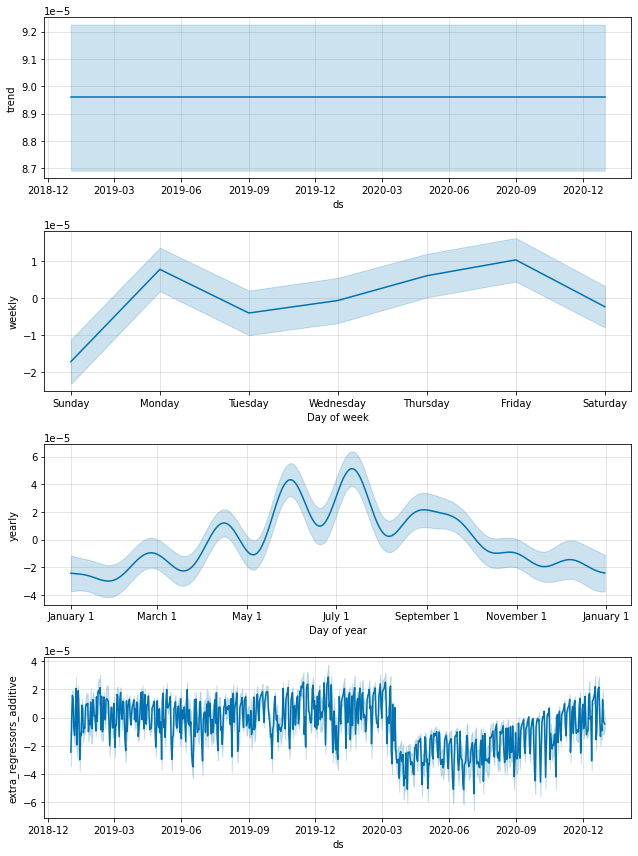

In [ ]:
df_no2_vehiculos['vehiculos'] = df_no2_vehiculos['vehiculos_observados']
resultados = m.predict(df_no2_vehiculos)
fig = m.plot_components(resultados)

Y los coeficientes estimados de las variables explicativas:

In [ ]:
coeficientes = regressor_coefficients(m)
coeficientes

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,precipitaciones,additive,0.000000,-2.496684e-05,-1.835745e-05,-0.000012
1,temperatura,additive,18.738864,-2.710075e-07,5.576864e-07,0.000001
2,vehiculos,additive,2.905814,1.081201e-05,1.358678e-05,0.000016


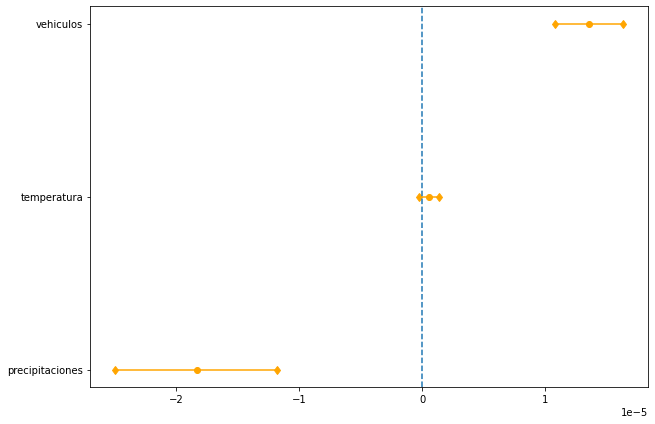

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
for lower, upper, center, y in zip(coeficientes['coef_lower'], coeficientes['coef_upper'], coeficientes['coef'], range(len(coeficientes))):
  ax.plot((lower,upper),(y,y),'d-',color='orange')
  ax.scatter(center, y, color='orange')
plt.yticks(range(len(coeficientes)),list(coeficientes['regressor']))
ax.axvline(x=0, linestyle = 'dashed')
plt.show()

*   ¿Qué puede decir de las estacionalidades detectadas por el modelo?
*   ¿Qué puede decir de las variables explicativas? ¿Cómo es su efecto estimado sobre la concentración de NO2?
*   ¿Cómo hubiese esperado que cambien los resultados si no se agrega la variable explicativa **vehiculos**? Puede comprobarlo comentando el código con un # (`#m.add_regressor('vehiculos')`) y volver a correr el entrenamiento y los resultados.
*   ¿Y si no se agrega una tendencia semanal? Puede comprobarlo cambiando `weekly_seasonality = True,` por `weekly_seasonality = False,`

Antes de continar, asegúrese de volver a modificar los cambios que realizó en código del entrenamiento del modelo. De lo contrario, esos cambios serán arrastrados a lo largo de la notebook.

##3. Predicciones con circulacion estimada
En esta sección utilizaremos el modelo entrenado en la sección anterior en conjunto con el conteo vehicular estimado por el modelo Prophet de la notebook anterior. El objetivo es realizar una predicción de la concentración de NO2 troposférico desde el inicio de la cuarentena 2020 si la circulación vehicular mantenia la misma tendencia que la observada en fechas anteriores.

En primer lugar, realizamos la predicción con este nuevo conjunto de datos. En este caso, la variable **vehiculos** es **vehiculos_predichos** y unimos las predicciones con las realizadas con **vehiculos_observados** en una misma tabla cuyas columnas corresponden a:
1.   **ds**
2.   **y**: Concentración troposférica de NO2 observada (μmol.m$^{-2}$)
3.   Si contiene *prediccion_*: Concentración troposférica de NO2 predicha (μmol.m$^{-2}$)
4.   Si contiene *_train*: Predicción utilizando el conteo vehicular observado
5.   Si contiene *_test*: Predicción utilizando el conteo vehicular predicho
6.   Si contiene *_max*: Valor máximo de la incerteza de la predicción
7.   Si contiene *_min*: Valor mínimo de la incerteza de la predicción



In [ ]:
df_no2_vehiculos_test = df_no2_vehiculos.copy()
df_no2_vehiculos_test['vehiculos'] = df_no2_vehiculos['vehiculos_predichos']
resultados_test = m.predict(df_no2_vehiculos_test)

resultados_train = resultados.copy()

resultados_train['prediccion_train'] = resultados_train['yhat']
resultados_train['prediccion_train_max'] = resultados_train['yhat_upper']
resultados_train['prediccion_train_min'] = resultados_train['yhat_lower']


resultados_test['prediccion_test'] = resultados_test['yhat']
resultados_test['prediccion_test_max'] = resultados_test['yhat_upper']
resultados_test['prediccion_test_min'] = resultados_test['yhat_lower']

df_no2_vehiculos_predicciones = df_no2_vehiculos[['ds', 'y']].merge(resultados_train[['ds', 'prediccion_train', 'prediccion_train_max', 'prediccion_train_min']], on = 'ds').merge(resultados_test[['ds', 'prediccion_test', 'prediccion_test_max', 'prediccion_test_min']], on = 'ds')
df_no2_vehiculos_predicciones


,ds,y,prediccion_train,prediccion_train_max,prediccion_train_min,prediccion_test,prediccion_test_max,prediccion_test_min
0,2019-01-01,0.000010,0.000037,0.000092,-1.750196e-05,0.000038,0.000094,-0.000017
1,2019-01-02,NaN,0.000062,0.000117,7.988754e-06,0.000059,0.000113,0.000004
2,2019-01-03,0.000080,0.000087,0.000142,3.138801e-05,0.000083,0.000139,0.000029
3,2019-01-04,0.000111,0.000089,0.000143,3.306504e-05,0.000090,0.000145,0.000035
4,2019-01-05,0.000047,0.000054,0.000109,4.524074e-08,0.000068,0.000121,0.000013
...,...,...,...,...,...,...,...,...
726,2020-12-27,NaN,0.000040,0.000095,-1.515293e-05,0.000053,0.000108,-0.000002
727,2020-12-28,NaN,0.000086,0.000142,3.221390e-05,0.000088,0.000143,0.000032
728,2020-12-29,NaN,0.000059,0.000115,3.939299e-06,0.000058,0.000113,0.000002
729,2020-12-30,NaN,0.000061,0.000116,5.704606e-06,0.000059,0.000114,0.000004


Realizamos el gráfico de las series de tiempo para observar más claramente las estimaciones:

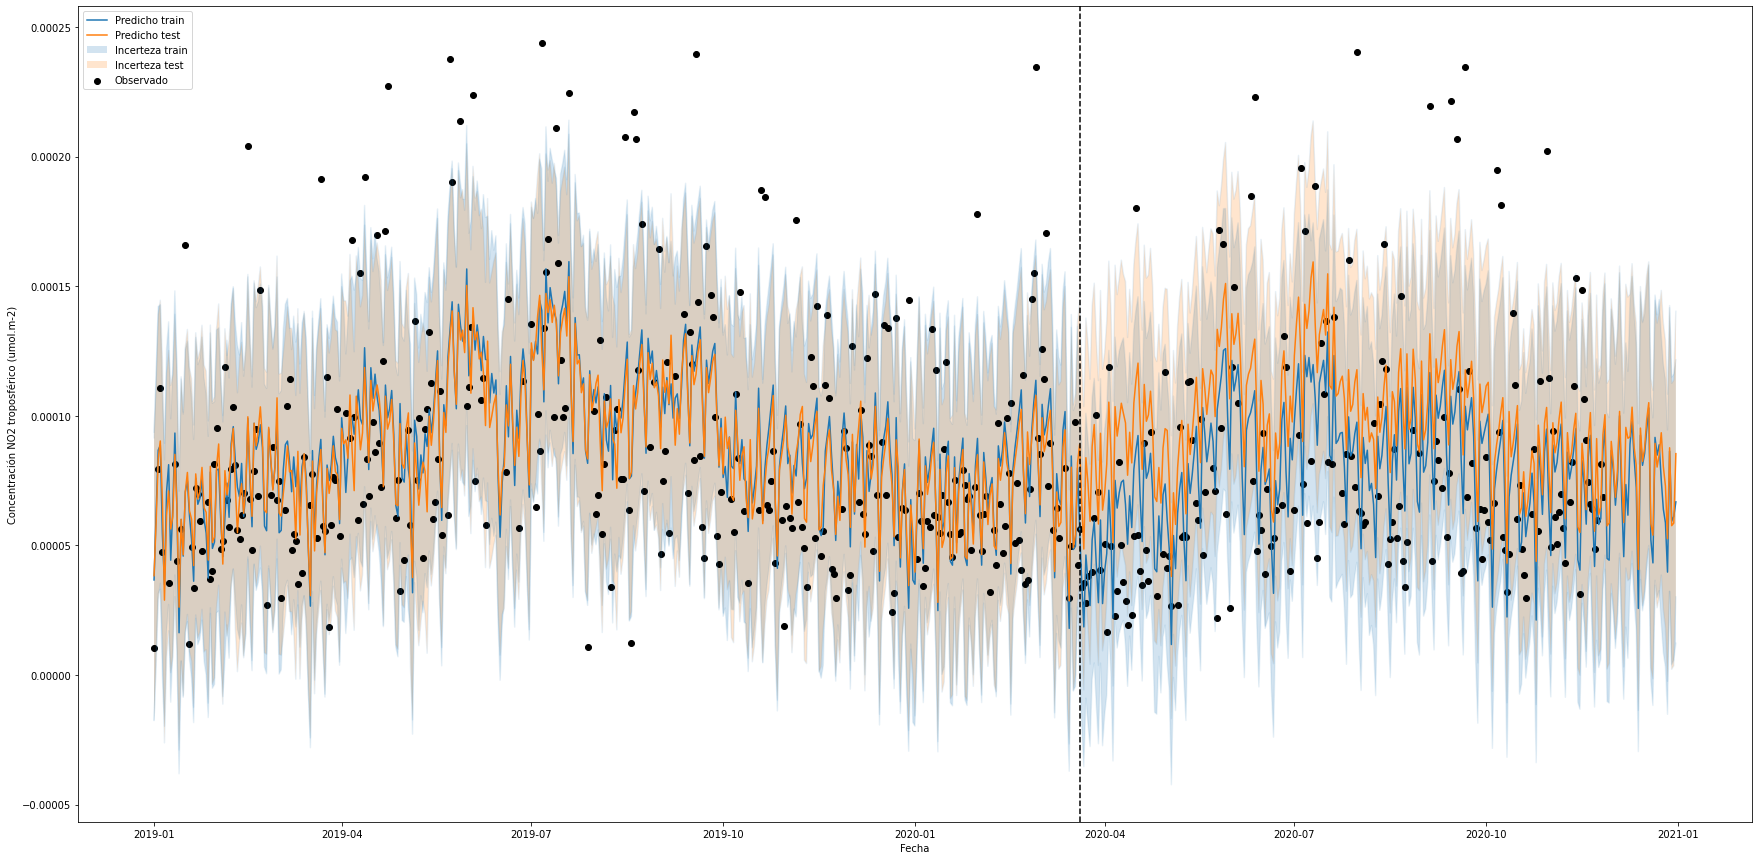

In [ ]:
fig, ax = plt.subplots(figsize=(30, 15))

for i in ['train', 'test']:
  predicho = 'prediccion_' + i
  ax.plot(df_no2_vehiculos_predicciones['ds'], df_no2_vehiculos_predicciones[predicho], label='Predicho ' + i)
  ax.plot(df_no2_vehiculos_predicciones['ds'], df_no2_vehiculos_predicciones[predicho + '_max'], color='tab:blue', alpha=0.1)
  ax.plot(df_no2_vehiculos_predicciones['ds'], df_no2_vehiculos_predicciones[predicho + '_min'], color='tab:blue', alpha=0.1)
  ax.fill_between(df_no2_vehiculos_predicciones['ds'], df_no2_vehiculos_predicciones[predicho + '_min'], df_no2_vehiculos_predicciones[predicho + '_max'], alpha=0.2, label='Incerteza ' + i)

ax.scatter(df_no2_vehiculos_predicciones['ds'], df_no2_vehiculos_predicciones['y'], color='black', label='Observado')

ax.axvline(x=dt.datetime(2020, 3, 20), color = 'black', linestyle = "dashed")

ax.legend(loc="upper left")
ax.set_xlabel('Fecha')
ax.set_ylabel('Concentración NO2 troposférico (umol.m-2)')
plt.show()

*   ¿A simple vista y teniendo en cuenta la naturaleza ruidosa de la serie temporal del NO2, son buenas las estimaciones? ¿Qué le llama la atención?
*   ¿Son similares las predicciones entre *train* (a partir del conteo vehicular observado) y *test* (a partir del conteo vehicular predicho)? 
*   ¿Se mantiene es similaridad después del inicio de la cuarentena obligatoria (línea vertical punteada)?


##5. Estimación de la reducción de la concentración de NO2
Finalmente, vamos a calcular la reducción de la concentración de NO2 troposférico comparando los predichos de *train* (Concentración de NO2 troposférico predicha utilizando al conteo vehicular observado) con los predichos de *test* (Concentración de NO2 troposférico predicha utilizando al conteo vehicular predicho):

Para hacerlo, se calculará el promedio de la concentración de NO2 para un intervalo de tiempo específico y se calculará la proporción *promedio train*/*promedio test*. Es decir que:
*   Proporción *promedio train*/*promedio test* ≈ 1 --> Predicciones de *train* y *test* similares
*   Proporción *promedio train*/*promedio test* > 1 --> Predicciones de *train* mayores a las de *test*: Se esperaba menos NO2 del observado
*   Proporción *promedio train*/*promedio test* < 1 --> Predicciones de *train* mayores a las de *test*: Se esperaba más NO2 del observado

El siguiente código realiza los cálculos descriptos y muestra los resultados en tres gráficos de barras:
1.   Comparación de *promedio train* y *promedio test* dentro de cada intervalo de tiempo. Las barras de error representan el intervalo de incerteza
2.   Comparación de *promedio train* y *promedio test* entra intervalos de tiempo. Las barras de error representan el intervalo de incerteza
3.   Proporción *promedio train*/*promedio test* para cada intervalo de tiempo. Estos resultados tambien muestran en una tabla

Modifique el objeto `intervalos` para comparar distintos intervalos de tiempo entre sí. Este objeto debe tener el siguiente formato:



```python
intervalos = [[fecha_inicial_1, fecha_final_1],
              [fecha_inicial_2, fecha_final_2],
              [fecha_inicial_3, fecha_final_3],
              ...
              [fecha_inicial_n, fecha_final_n]]
```
Donde cada par `[fecha_inicial_n, fecha_final_n]` representa un intervalo de tiempo y cada fecha sigue el formato 'YYYY-MM-DD'.


,Intervalo,Proporción promedio train/promedio test
0,"['2019-01-01', '2020-03-20']",1.015756
1,"['2020-03-20', '2020-12-31']",0.814216
2,"['2020-04-01', '2020-05-01']",0.709154
3,"['2020-05-01', '2020-06-01']",0.787812
4,"['2020-06-01', '2020-07-01']",0.807668
5,"['2020-07-01', '2020-08-01']",0.809309
6,"['2020-08-01', '2020-09-01']",0.817743
7,"['2020-12-01', '2021-01-01']",0.913147


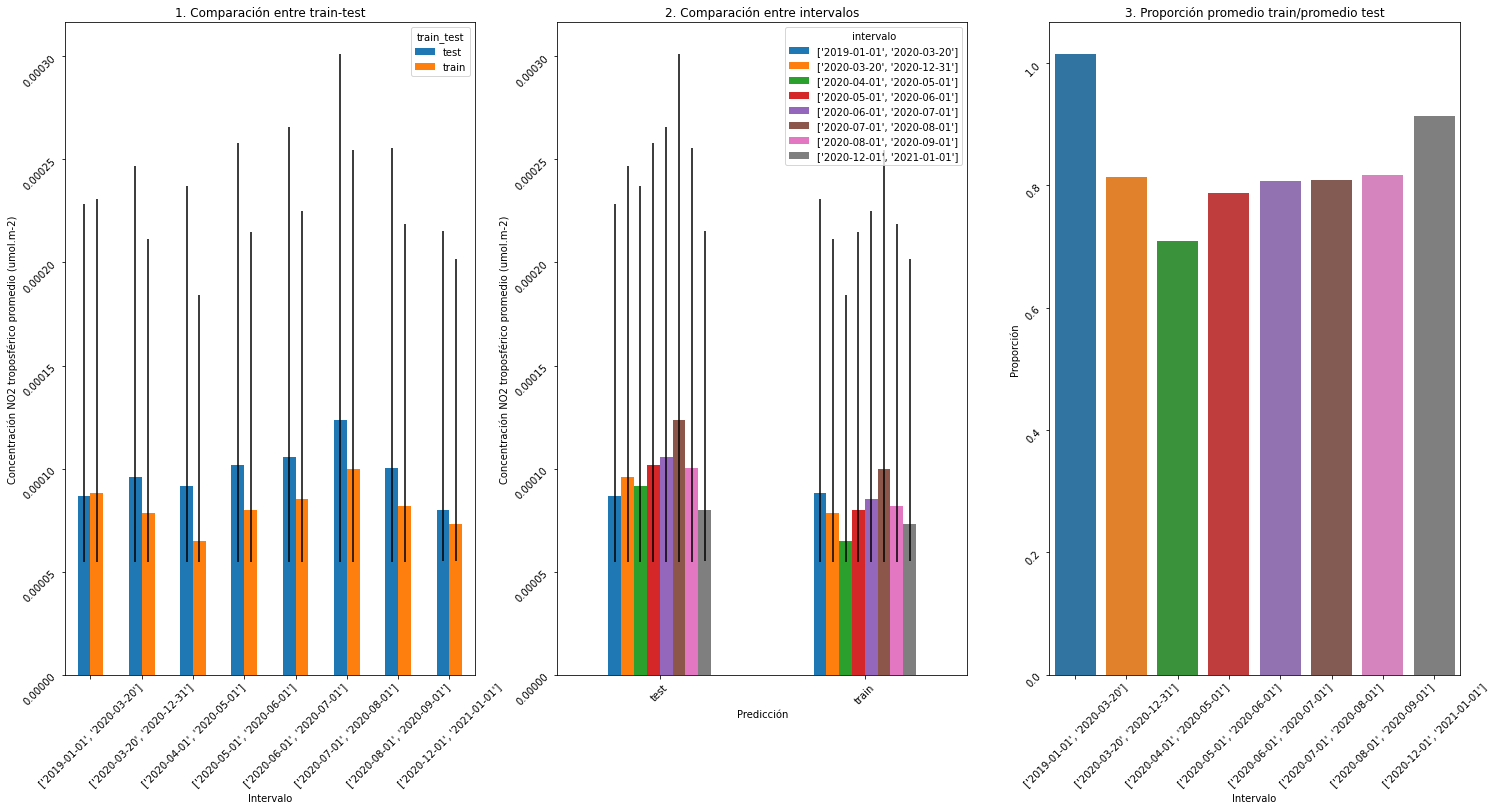

In [ ]:
##### Modifique las siguientes líneas de código #####
intervalos = [['2019-01-01', '2020-03-20'],
              ['2020-03-20', '2020-12-31'],
              ['2020-04-01', '2020-05-01'],
              ['2020-05-01', '2020-06-01'],
              ['2020-06-01', '2020-07-01'],
              ['2020-07-01', '2020-08-01'],
              ['2020-08-01', '2020-09-01'],
              ['2020-12-01', '2021-01-01']]





##### NO modifique las siguientes líneas de código #####
df_final = pd.DataFrame()
for i in intervalos:
  df_it = df_no2_vehiculos_predicciones[(df_no2_vehiculos_predicciones['ds'] >= i[0]) & (df_no2_vehiculos_predicciones['ds'] <= i[1])]
  df_it = df_it.agg({'prediccion_train': 'mean',
                     'prediccion_test': 'mean',
                     'prediccion_train_max': 'mean',
                     'prediccion_test_max': 'mean',
                     'prediccion_train_min': 'mean',
                     'prediccion_test_min': 'mean'}).reset_index().rename(columns = {'index': 'prediccion',
                                                                                  0: 'area'})
  df_it['intervalo'] = str(i)
  df_final = df_final.append(df_it)

df_final['train_test'] = np.where(df_final['prediccion'].str.contains('train'), 'train', 'test')
df_final = df_final.groupby(['intervalo', 'train_test']).agg(medio = ('area', 'median'),
                                                  minimo = ('area', 'min'),
                                                  maximo = ('area', 'max')).reset_index()

#print(df_final)

df_final_wide = df_final.pivot(index = 'intervalo', columns = 'train_test', values = ['medio', 'minimo', 'maximo']).reset_index()
df_final_wide.columns = ["_".join(a) for a in df_final_wide.columns.to_flat_index()]
for i in ['medio']:#, 'minimo', 'maximo']:
  df_final_wide[i + '_train_test'] = df_final_wide[i + '_train'] / df_final_wide[i + '_test']

#df_final_wide['minimo_train_test'] = df_final_wide['medio_train_test'] - df_final_wide['minimo_train_test']
#df_final_wide['maximo_train_test'] = df_final_wide['maximo_train_test'] - df_final_wide['medio_train_test']

#Graficos:
def func(x,y,h,lb,ub, **kwargs):
    data = kwargs.pop("data")
    # from https://stackoverflow.com/a/37139647/4124317
    errLo = data.pivot(index=x, columns=h, values=lb)
    errHi = data.pivot(index=x, columns=h, values=ub)
    err = []
    for col in errLo:
        err.append([errLo[col].values, errHi[col].values])
    err = np.abs(err)
    p = data.pivot(index=x, columns=h, values=y)
    p.plot(kind='bar',yerr=err,ax=plt.gca(), **kwargs)

fig, axs = plt.subplots(ncols=3, figsize=(25, 12))

plt.sca(axs[0])
func("intervalo", "medio", "train_test", "minimo", "maximo", data=df_final)
plt.title("1. Comparación entre train-test")
plt.ylabel("Concentración NO2 troposférico promedio (umol.m-2)")
plt.xlabel("Intervalo")
axs[0].tick_params(labelrotation=45)

plt.sca(axs[1])
func("train_test", "medio", "intervalo", "minimo", "maximo", data=df_final)
plt.title("2. Comparación entre intervalos")
plt.ylabel("Concentración NO2 troposférico promedio (umol.m-2)")
plt.xlabel("Predicción")
axs[1].tick_params(labelrotation=45)

plt.sca(axs[2])
sns.barplot(x="intervalo_", y="medio_train_test", data=df_final_wide)
plt.title("3. Proporción promedio train/promedio test")
plt.ylabel("Proporción")
plt.xlabel("Intervalo")
axs[2].tick_params(labelrotation=45)

df_final_wide[['intervalo_', 'medio_train_test']].rename(columns = {'intervalo_': 'Intervalo',
                                                                    'medio_train_test': 'Proporción promedio train/promedio test'})

*   ¿Fueron similares las estimaciones de *train* y *test antes de la cuarentena?
*   ¿Cuanto se redujo el NO2 en la cuarentena?
*   ¿Hubo diferencias de la reducción el los distintos meses durante la cuarentena? ¿Cuál fue el mes con mayor reducción?

##6. Conclusión
En esta notebook se buscó cuantificar la diferencia entre la concentración de NO2 troposférico observado en el 2020 y el esperado de no haber habido cuarentena por COVID-19. Sabiendo que el valor real nunca podría ser medido fehacientemente, se realizaron distintos modelos para tratar de imitar de la forma más fiel posible el comportamiento del NO2 y así reconstruir un escenario hipotético. 

Pudimos observar que la ocurrencia de precipitaciones y el conteo vehicular son variables importantes para explicar la concentración troposférica de NO2. En concordancia con la bibliografía, a ocurrencia de lluvias el NO2 es menor y a mayor circulación vehicular mayor NO2. Sin embargo, el comportamiento de la concentración de este gas es muy erratico, ya sea por errores de medición o por otros factores no incluídos en este análsis. Sin embargo, con solo dos variables adicionales, pudimos estimar que la concentración de NO2 troposférico se redujo un 20% entre el 20 de marzo y el 31 de diciembre del 2020, pero que esta reducción no fue estable en este período. El mes con la mayor reducción fue abril, con un 30%, mientras que en diciembre fue del 9%.

Está claro que la concentración de NO2 no esta definida por la circulación vehicular y la occurrencia de precipitaciones, por lo que, a fin de mejorar los resultados obtenidos, es necesario incorporar otras variables que podrían estar involucradas, como la intensidad y dirección de los vientes troposféricos y otras actividades industriales y comerciales que emiten en gas, además de mediciones más precisas in situ.